# Let's run this on kaggle

In [1]:
import os
import torch

from torchvision import *
from torch_snippets import *
from torch.utils.data import DataLoader
from torchvision.models import vgg16_bn
from sklearn.model_selection import train_test_split

# Do we have a working GPU?
device = 'cuda' if torch.cuda.is_available() else 'gpu'

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f'Using GPU: {gpu_name}')
else:
    print(f'Using device: {device}')

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU

In [3]:
transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])
                ])

In [31]:
class SegData(Dataset):
    def __init__(self, split):
        data_dir = r"C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray"
        self.split = split
        self.items = stems(os.path.join(data_dir,split,'image'))
        self.images_dir = os.path.join(data_dir,split, 'image')
        self.masks_dir  = os.path.join(data_dir, split, 'mask')

    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, ix):
        img_path = os.path.join(self.images_dir, f'{self.items[ix]}.png')  # Path to the image
        mask_path = os.path.join(self.masks_dir, f'cxrmask_{self.items[ix].split("_")[-1]}.jpeg')  # Path to the mask

        print(f'Image path: {img_path}')
        print(f'Mask path: {mask_path}')

        image = read(img_path,1)
        if image is None:
            raise RuntimeError(f'Failed to load mask from {img_path}')
        
        image = cv2.resize(image,(224,224))
        
        mask = read(mask_path,0) 
        if mask is None:
            raise RuntimeError(f'Failed to load mask from {mask_path}')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    
    def choose(self): 
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([transforms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [32]:
train_ds = SegData('train')
val_ds   = SegData('test')
train_dl = DataLoader(train_ds, batch_size= 4, shuffle= True, collate_fn= train_ds.collate_fn)
val_dl   = DataLoader(val_ds, batch_size= 1, shuffle=True, collate_fn= val_ds.collate_fn)

Image path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\image\cxrimage_1.png

Mask path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\mask\cxrmask_1.jpeg

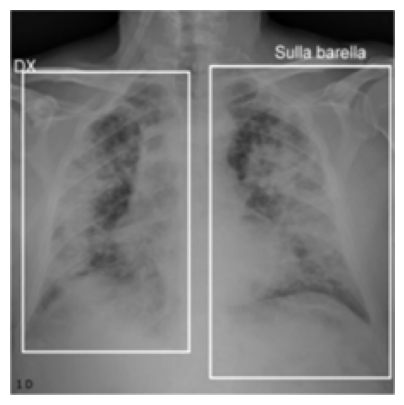

In [54]:
# Show the a random image here
show(train_ds[1][0])

In [48]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace=True)
        )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [49]:
class UNet(nn.Module):
    def __init__(self, pretrained = True, out_channels=12):
        super().__init__()
        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [50]:
ce= nn.CrossEntropyLoss()
def UnetLoss(pred, targets):
    ce_loss = ce(pred,targets)
    acc = (torch.max(pred,1)[1] == targets).float().mean()
    return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [51]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 20

c:\Users\18126\miniconda3\envs\Torchcv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\18126\miniconda3\envs\Torchcv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

Image path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\image\cxrimage_5795.png

Mask path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\mask\cxrmask_5795.jpeg

Image path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\image\cxrimage_14711.png

Mask path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\mask\cxrmask_14711.jpeg

Image path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\image\cxrimage_4624.png

Mask path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\mask\cxrmask_4624.jpeg

Image path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\image\cxrimage_8453.png

Mask path: C:\BC\SP_24\Computer_Vision\Discussions\Discussion10\Data\ChestXray\train\mask\cxrmask_8453.jpeg

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 14 for tensor number 1 in the list.

In [ ]:
log.plot_epochs(['trn_loss', 'val_loss'])

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask,dim = 1)
subplots([im[0].permute(1,2,0).detach().cpu[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],
          nc=3, titles=['Original image', 'Original Mask', 'Predicted Mask'])